# Assignment: Unsupervised Machine Learning \ Clustering

## Part 1: Partitional Clustering

In this assignment you will experience with partitional & mixture model clustering. The analyses are made on real datasets under the circumstances of real life challenges in unsupervised machine learning.

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

### Read blood test results as an EMR from an Excel file

In [2]:
# Open the file
xlsx = pd.ExcelFile('EMR-Blood.xlsx')

# Get the first sheet as an object
sheet1 = xlsx.parse(0)

# Set the Key column as the index
sheet1.set_index("Key", inplace=True)

# Show first 10 rows
sheet1[:10]

,Na,K,ALT,AST,WBC,RBC,Hgb,Hct
Key,,,,,,,,
1,141,4.65,31.92,35.01,10.25,4.06,17.6,36.3
2,140,4.96,36.41,16.70,6.13,3.80,13.2,35.6
3,136,3.66,41.43,13.17,5.86,4.26,16.2,43.7
4,136,4.74,23.92,30.33,10.80,4.83,16.1,49.8
5,140,4.74,43.66,20.44,6.59,4.05,12.6,39.1
6,146,3.98,48.41,33.22,4.53,4.04,17.9,47.3
7,144,5.29,44.29,19.28,10.12,3.96,17.2,47.9
8,138,4.57,50.43,16.39,4.66,4.91,13.7,41.5
9,144,3.96,31.51,34.87,4.57,4.72,15.1,47.6


### Blood Test Abbreviations
- Na == Sodium
- K == Potassium
- ALT == Alanine transaminase
- AST == Aspartate transaminase
- WBC == White blood cells
- RBC == Red blood cells
- Hgb == Hemoglobin
- Hct == Hematocrit

### Use K-Means to create clusters according to variables of uniform distribution

In [3]:
# Retrieve the K, WBC and Hgb column values from the dataset to cluster
variables1 = ["K","WBC","Hgb"]
EMR3d1 = sheet1.loc[:, variables1].values

# Run the K-Means algorithm, assuming the correct number of clusters is 5
y_pred_KMeans1 = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(EMR3d1)
#print(pd.DataFrame(y_pred_KMeans1.labels_))
labels = y_pred_KMeans1.labels_
#print(y_pred_KMeans1.cluster_centers_)


### Make a 3D chart

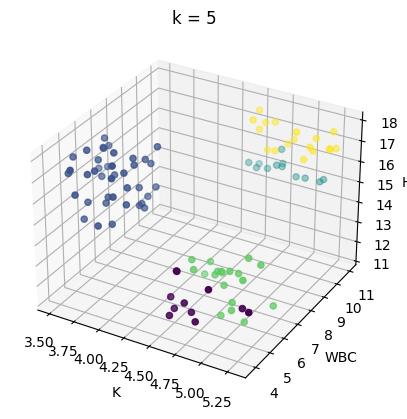

In [4]:
def make_chart (chart_data, y_pred, labels, k):
    fig = plt.figure()

    ax = fig.add_subplot(projection='3d', title='k = %i'%k)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.scatter(chart_data[:,0], chart_data[:,1], chart_data[:,2], c=y_pred)

make_chart(EMR3d1, labels, variables1, 5)

## Task 1 (_max score - 50 points_)
Implement  Lloyd's Algorithm for solving the K-Means problem, as shown in class.
By examining the WCSS, choose a proper threshold to determine algorithm convergence.

Check your algorithm on 'EMR-Blood.xlsx' dataset. Compare your results to the _sklearn_ version - what can affect any differences you might've got?

  There are difference in results due to first step - which centroids we choose for 1 time.

In [5]:
from ctypes import pointer
# Add your code for task1 after this line, and keep it in this cell.

# Implement K-Means (X being the data)
class k_means:
    def __init__(self, k, random_state=1, num_iter=50, min_distance=1e-3):
        self.k = k
        self.num_iter = num_iter
        self.min_distance = min_distance
        self.random_state = random_state

    def coner_centroids(self,X):
      min_max_X = np.array([X.T.min(axis=1), X.T.max(axis=1)])
      p = X.shape[1]
      binary = []
      for i in range(2**p):
          binary.append(list(format(i, f'0{p}b')))
      binary = np.array([eval(i) for l in binary for i in l]).reshape(-1,p)
      np.random.shuffle(binary)
      print(p, self.k)
      if 2 ** p >= self.k:
        return min_max_X.T[np.arange(p),binary[:self.k]]
      else:
        x = []
        for i in range(p):
            x.append(np.random.uniform(low=min_max_X[0,i],high=min_max_X[1,i], size=(self.k - 2 ** p)))
        x = np.array(x).T
        x = np.concatenate((x,min_max_X.T[[0,1,2],binary]), axis=0)
        return x

    def kmeanspp_centroids(self, X):
      np.random.seed(self.random_state)
      centroids = []
      centroid_id = np.random.choice(X.shape[0])
      centroids.append(X[centroid_id])
      for _ in range(self.k-1):
        dists = []
        for x in X:
            distances = np.sqrt(np.sum((x-centroids)**2,axis=1))
            dists.append(distances.min())
        obj_ind = np.array(dists).argmax()
        next_centroid = X[obj_ind]
        centroids.append(next_centroid)
      return np.array(centroids)

    def random_centroids(self, X):
      p = X.shape[1]
      min_max_X = np.array([X.T.min(axis=1), X.T.max(axis=1)])
      x = []
      for i in range(p):
          x.append(np.random.uniform(low=min_max_X[0,i],high=min_max_X[1,i], size=(self.k)))
      x = np.array(x).T
      return x



    def fit(self, X):
        self.X = X
        p = X.shape[1]
        k = self.k
        num_iter = self.num_iter
        min_distance = self.min_distance

        #initiation of centroids
        centroids = self.kmeanspp_centroids(X)
        #centroids = self.corner_centroids(X)
        #centroids = self.random_centroids(X)
        new_centroids = centroids.copy()

        n=0
        wcss_old = 100000000

        while (n == 0)|((n < num_iter)):
          belong_to_centroid = []
          wcss = 0
          for x in X:
            distances = np.sqrt(np.sum((new_centroids-x)**2,axis=1))
            belong_to_centroid.append(np.argmin(distances))
            wcss += np.min(np.sqrt(np.sum((new_centroids-x)**2,axis=1)))


          new_centroids2=np.ones((1,p))

          for cluster in np.arange(k):
            new_centroid = np.mean(X[np.argwhere(belong_to_centroid==cluster)], axis=0)
            new_centroids2 = np.concatenate((new_centroids2,new_centroid), axis=0)

          new_centroids = new_centroids2[1:]
          n += 1

          if abs(wcss- wcss_old) <= min_distance:
            self.centroids = new_centroids
            self.belong_to_centroid = belong_to_centroid
            self.wcss = wcss
            return belong_to_centroid
          wcss_old =wcss

        self.wcss = wcss
        self.belong_to_centroid = belong_to_centroid
        self.centroids = new_centroids
        return centroids

    def predict(self, X):
        centroids = self.centroids
        belong_to_centroid = []
        for x in X:
            distances = np.sqrt(np.sum((centroids-x)**2,axis=1))
            belong_to_centroid.append(np.argmin(distances))
        return belong_to_centroid


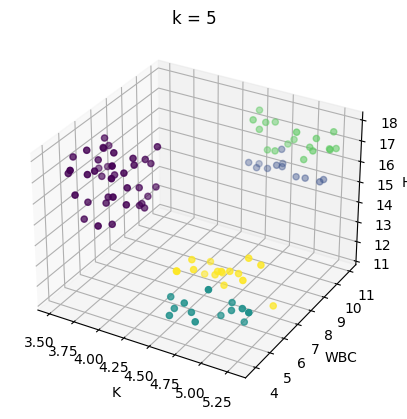

In [6]:
model = k_means(5,random_state=15)
model.fit(EMR3d1)
labels2 = model.belong_to_centroid
#print(labels2)
#print(y_pred_KMeans1.cluster_centers_)
make_chart(EMR3d1, labels2, variables1, 5)

## Task 2 (_max score - 30 points_)

Humans can clearly spot 3 clusters, however, for machines it's much harder to "learn" that. In the above implementation, K-Means was given the value of 5 as K.
Develop a **generic** mechanism for finding the most reasonable number of clusters by:
1. Iterating K over a reasonable range, which should be derived from the number of points
2. Choose a proper K based on the heuristics learned in class
3. Showing the final clusters in a 3D chart (for your implementation of K-Means algorithm)

Difference of WCSS between k = 1 and 2  :  117.23653527117719
Difference of WCSS between k = 2 and 3  :  71.31335450559644
Difference of WCSS between k = 3 and 4  :  12.940120638683737
Difference of WCSS between k = 4 and 5  :  9.58468624163892
Difference of WCSS between k = 5 and 6  :  10.526891156927888
Difference of WCSS between k = 6 and 7  :  8.172121577319118
Difference of WCSS between k = 7 and 8  :  4.060149172918635
Difference of WCSS between k = 8 and 9  :  6.889810264654024
Difference of WCSS between k = 9 and 10  :  3.109498407679368
Difference of WCSS between k = 10 and 11  :  3.0126970290570085
Difference of WCSS between k = 11 and 12  :  2.4265651924455227
Difference of WCSS between k = 12 and 13  :  2.093055884340103
Difference of WCSS between k = 13 and 14  :  1.1937524634106609
Difference of WCSS between k = 14 and 15  :  1.3337923113783887
Optimal k=3


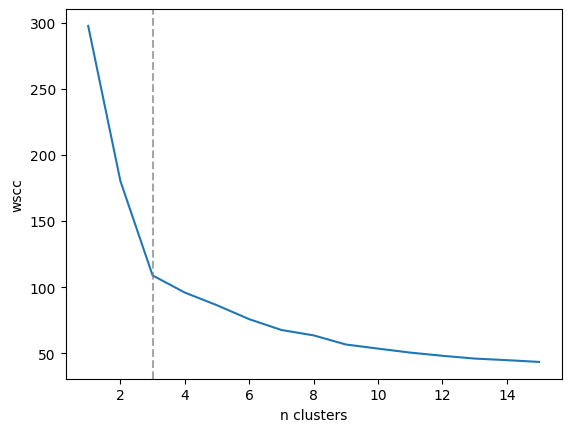

In [56]:
# Add your code for task2 after this line, and keep it in this cell.
wcss = []
wcss_dif = {}
for k in range(1,16):
  model = k_means(k,random_state=15)
  model.fit(EMR3d1)
  labels2 = model.belong_to_centroid
  #make_chart(EMR3d1, labels2, variables1, k)
  wcss.append(model.wcss)
  if k != 1:
    dif = {f'Difference of WCSS between k = {k-1} and {k}': wcss[k-2]-wcss[k-1]}
    wcss_dif.update(dif)
#print(wcss)
for key, value in wcss_dif.items():
    print(key, ' : ', value)
wcss_dif_list = list(wcss_dif.values())
minimum = wcss_dif_list[1]/wcss_dif_list[0]
optimal_k = -1
for i in range(len(wcss_dif_list)-1):
  if (wcss_dif_list[i+1]/wcss_dif_list[i]) <= minium:

    minimum = wcss_dif_list[i+1]/wcss_dif_list[i]
    optimal_k = i+2

print('Optimal k=%i'%optimal_k)
plt.plot(np.arange(1, 16), wcss)
plt.axvline(x=3, color='gray', alpha=0.7, linestyle='--')
plt.xlabel('n clusters')
plt.ylabel('wscc');





$$k_{opt} = argmin(\frac{diffwcss_{k+1}-diffwcss_{k}}{diffwcss_{k}-diffwcss_{k-1}})$$

From a graph and difference of WCSS for different k, we see that k optimal are 3. After k=3 difference of WCSS changes more slowly than before.

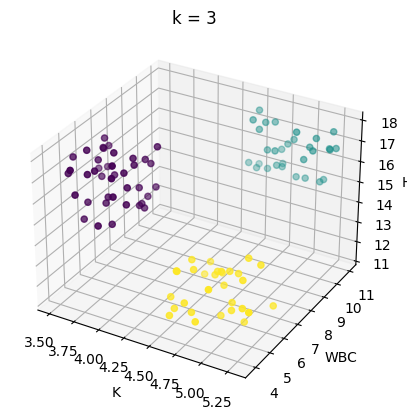

In [8]:
model = k_means(3,random_state=15)
model.fit(EMR3d1)
labels2 = model.belong_to_centroid
#print(labels2)
#print(y_pred_KMeans1.cluster_centers_)
make_chart(EMR3d1, labels2, variables1, 3)

### Silhouette analysis

Use graphic visualization of the Silhouette score to support your above answer:

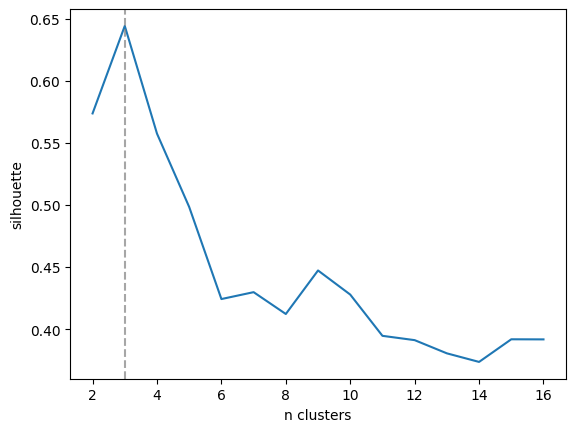

In [36]:
# Add your code for the Sillhouette graphic analysis
# You can use scikit-learn Sillhouette page as a reference

from sklearn.metrics import silhouette_samples, silhouette_score

def plot_Silhouette(X, num_clusters):
    # YOUR CODE HERE
    y_pred_KMeans1 = KMeans(n_clusters=num_clusters, random_state=0, n_init="auto").fit(X)
    labels = y_pred_KMeans1.labels_
    #print(silhouette_samples(X, labels, metric='euclidean'))
    return silhouette_score(X, labels, metric='euclidean')
silhouette = []
for k in range(2,17):
  silhouette.append(plot_Silhouette(EMR3d1, k))
plt.plot(np.arange(2, 17), silhouette)
plt.axvline(x=3, color='gray', alpha=0.7, linestyle='--')
plt.xlabel('n clusters')
plt.ylabel('silhouette');

#### From this section on - please use the sklearn's K-means

## Part 2: Mixture Models Clustering

### Use K-Means to create clusters according to variables of both uniform and Gaussian distributions

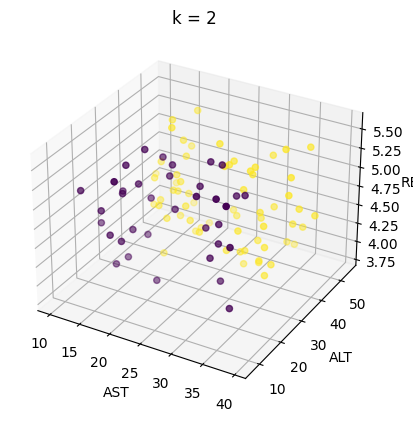

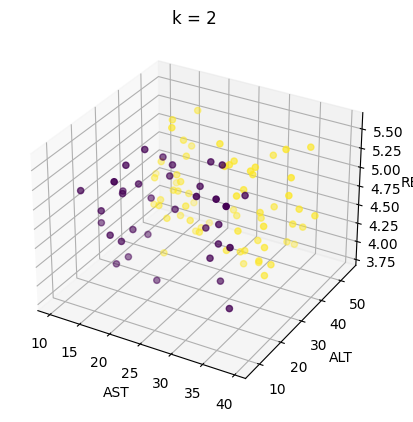

In [21]:
# Retrieve the ALT, AST and RBC column values from the dataset to cluster
variables2 = ["AST","ALT","RBC"]
EMR3d2 = sheet1.loc[:, variables2].values

# Run the K-Means algorithm
# NOTICE, this time, we know that the correct number of clusters is 2
model = k_means(2,random_state=15)
model.fit(EMR3d2)
y_pred_KMeans2 = model.belong_to_centroid

# Make a 3D chart
make_chart(EMR3d2, y_pred_KMeans2, variables2,2)

y_pred_KMeans1 = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(EMR3d2)
y_pred_KMeans2 = y_pred_KMeans1.labels_
make_chart(EMR3d2, y_pred_KMeans2, variables2,2)

## Task 3 (_max score - 20 points_)
Scientists have found that in this population of patients, RBC distribution is uniform, ALT distribution is a Gaussian and AST distribution is a mixture of two Gaussians. Clearly, even by giving K-Means the correct K, the algorithm got to the wrong conclusion. This separation is "technically" correct, but lacks some underlying understanding of the natural phenomena.

What is the "problem" with this separation?

In [ ]:
# Your answer here


In order to exploit the Gaussian characteristic of the AST
1. Find the 2 componenets that comprise the AST feature by applying the GMM algorithm with the proper number of components.
2. Assume that the clusters above are correct for the entire dataset (including the other features).
3. Show the final clusters (of EMR3d2) in a 3D chart

In [ ]:
# Add your code for task3 after this line, and keep it in this cell.




What is the difference between the two clustering results above?

Which one, given the domain knowledge provided to you, makes more sense?




# Good Luck!

